In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

In [2]:
image_size=128
data_path='data'
classes=['Closed','no_yawn','Open','yawn']
images=[]
labels=[]

for label,cls in enumerate(classes):
    cls_path=os.path.join(data_path,cls)
    for img_name in os.listdir(cls_path):
        if img_name.endswith(('.jpg','.jpeg','.png')):
            img_path=os.path.join(cls_path,img_name)
            img=cv2.imread(img_path)
            if img is not None:
                img=cv2.resize(img,(image_size,image_size))
                img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                labels.append(label)
x=np.array(images)
y=np.array(labels)

In [3]:
x.shape

(2900, 128, 128, 3)

In [4]:
y.shape

(2900,)

In [5]:
x=x/255.0
y=to_categorical(y,num_classes=len(classes))

In [6]:
#features shape
x.shape

(2900, 128, 128, 3)

In [7]:
#target shape
y.shape

(2900, 4)

In [8]:
print(f"Total images: {len(x)}")
print(f"Images dimensions: {x[0].shape}")
print(f"Claases: {classes}")

Total images: 2900
Images dimensions: (128, 128, 3)
Claases: ['Closed', 'no_yawn', 'Open', 'yawn']


In [9]:
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.2,random_state=42,stratify=np.argmax(y,axis=1))

In [10]:
def evaluate_model(true,predicted):
    true_classes=np.argmax(true, axis=1)
    pred_classes=np.argmax(predicted, axis=1)
    accuracy=accuracy_score(true_classes, pred_classes)
    return accuracy

In [11]:
def simple_cnn():
    model=Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(image_size,image_size,3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(len(classes), activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def deep_cnn():
    model=Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(image_size,image_size,3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(classes), activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def batchnorm_cnn():
    model=Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(image_size,image_size,3)),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(classes), activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

models={
    "Simple CNN": simple_cnn,
    "Deep CNN": deep_cnn,
    "BatchNorm CNN": batchnorm_cnn
}

In [12]:
model_list=[]
accuracy_list=[]

for i in range(len(list(models))):
    model_name=list(models.keys())[i]
    model_func=list(models.values())[i]
    model=model_func()

    model.fit(x_train, y_train, validation_split=0.2, epochs=15, batch_size=32, verbose=0)

    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    model_train_accuracy = evaluate_model(y_train, y_train_pred)
    model_test_accuracy = evaluate_model(y_test, y_test_pred)

    print(model_name)
    model_list.append(model_name)

    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Accuracy: {:.4f}".format(model_test_accuracy))
    accuracy_list.append(model_test_accuracy)
    
    print('='*35)

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Simple CNN
Model performance for Training set
- Accuracy: 0.9621
----------------------------------
Model performance for Test set
- Accuracy: 0.9241
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Deep CNN
Model performance for Training set
- Accuracy: 0.9772
----------------------------------
Model performance for Test set
- Accuracy: 0.9397
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
BatchNorm CNN
Model performance for Training set
- Accuracy: 0.9168
----------------------------------
Model performance for Test set
- Accuracy: 0.8759


In [14]:
pd.DataFrame(list(zip(model_list, accuracy_list)), columns=['Model Name', 'Accuracy']).sort_values(by=['Accuracy'], ascending=False)

,Model Name,Accuracy
1,Deep CNN,0.939655
0,Simple CNN,0.924138
2,BatchNorm CNN,0.875862


In [16]:
best_model=deep_cnn()
best_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32, verbose=1)

y_pred=best_model.predict(x_test)
accuracy=evaluate_model(y_test, y_pred) * 100
print("Accuracy of the model is %.2f" %accuracy)

Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.6672 - loss: 0.7046 - val_accuracy: 0.8241 - val_loss: 0.3905
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.8034 - loss: 0.4088 - val_accuracy: 0.8362 - val_loss: 0.3177
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.8233 - loss: 0.3535 - val_accuracy: 0.8534 - val_loss: 0.2933
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.8284 - loss: 0.3307 - val_accuracy: 0.8517 - val_loss: 0.3016
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.8513 - loss: 0.2978 - val_accuracy: 0.8707 - val_loss: 0.2511
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.8677 - loss: 0.2704 - val_accuracy: 0.8707 - val_loss: 0.2625
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.8612 - loss: 0.2895 - val_accuracy: 0.8707 - val_loss: 0.2613
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.8901 - loss: 0.2509 - val_accuracy: 0.8897

Text(70.72222222222221, 0.5, 'Actual')

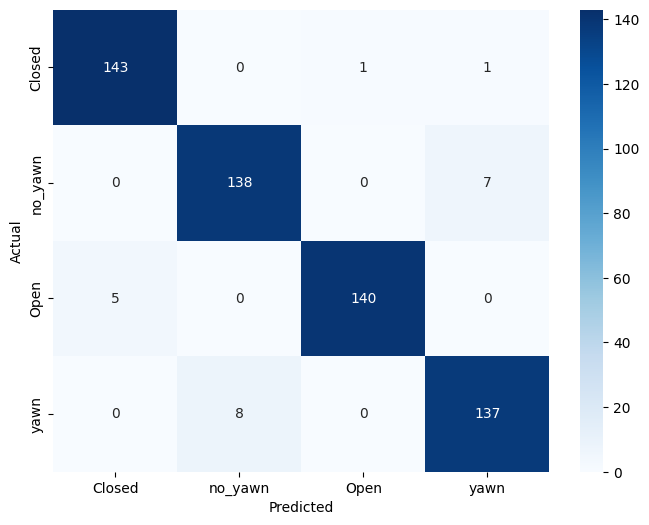

In [17]:
y_pred_classes=np.argmax(y_pred, axis=1)
y_test_classes=np.argmax(y_test, axis=1)
cm=confusion_matrix(y_test_classes, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [20]:
pred_df=pd.DataFrame({'Actual Class': [classes[i] for i in y_test_classes],
                      'Predicted Class': [classes[i] for i in y_pred_classes],
                      'Match': y_test_classes==y_pred_classes
                      })
pred_df

,Actual Class,Predicted Class,Match
0,no_yawn,no_yawn,True
1,yawn,yawn,True
2,Closed,Closed,True
3,yawn,yawn,True
4,Open,Open,True
...,...,...,...
575,no_yawn,no_yawn,True
576,Open,Open,True
577,yawn,yawn,True
578,no_yawn,no_yawn,True
